## Load the libraries

In [234]:
import numpy as np
import networkx as nx
import scipy.io as sio
import slam.mapping as smap
import trimesh
import matplotlib.pyplot as plt

## Stereo visualisation by using networkx

### Get the planar coordinates of the graphs

In [46]:
my_graph = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_3.0,outliers_4/0/ref_graph.gpickle")
my_graph_noisy = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_3.0,outliers_4/0/noisy_graph.gpickle")

In [131]:
def get_planar_coords_in_graph(graph, distance_to_remove_outliers = 100):
    """
    Compute the planar coordinates for the graph
    and add them to each node in the graph
    """
    
    # Create the node array to be used in the mesh
    node_array = np.array([graph.nodes[node]["coord"] for node in graph.nodes])
    # We also keep track of which node correspond to which line in the matrix
    node_correspondence = [node for i,node in enumerate(graph.nodes)]
    
    #print(node_correspondence)
    
    # transform in a mesh
    trimesh_test = trimesh.Trimesh(vertices=node_array)
    planar_coords = smap.stereo_projection(trimesh_test, h=-100)
    
    # Fix the coordinates of the north_pole and sphere radius
    radius = 100
    north_pole = np.array([0,0,100])
    
    # Fill the new coordinates
    dict_attributes = {}
    for i in range(graph.number_of_nodes()):
        
        node_num = node_correspondence[i]
        # Calculate the distance to north pole
        original_coords = graph.nodes[node_num]["coord"]
        distance_to_north_pole = np.linalg.norm(original_coords - north_pole)
        attr_val = np.array(planar_coords.vertices[i][:2])
        
        # If it is not an outlier :
        if np.linalg.norm(attr_val) < distance_to_remove_outliers:
            attr_val = np.array(planar_coords.vertices[i][:2])
            dict_attributes[node_num] = {"coord2D": attr_val}
        
        # otherwise we remove the node
        else:
            graph.remove_node(node_num)
        
    nx.set_node_attributes(graph,dict_attributes)

In [132]:
#get_planar_coords_in_graph(my_graph)
my_graph_noisy = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_3.0,outliers_4/0/noisy_graph.gpickle")
get_planar_coords_in_graph(my_graph_noisy,500)
get_planar_coords_in_graph(my_graph,500)

### Visualise it using networkx

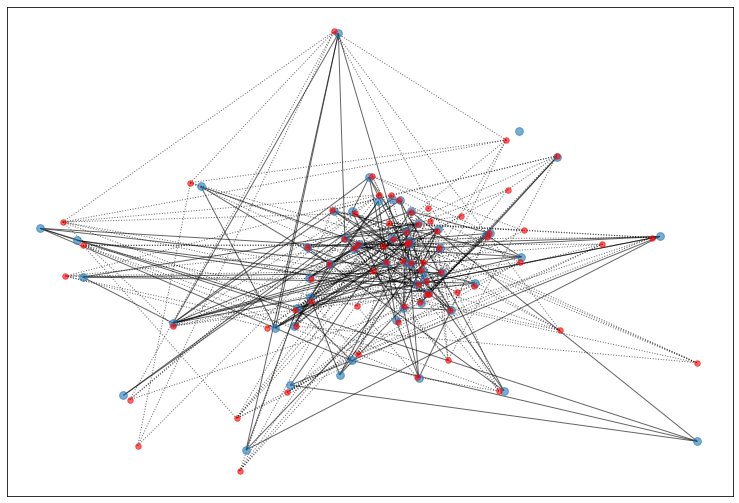

In [133]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(13,9))

# Get te position dictionnary
my_pos = {node: my_graph.nodes[node]["coord2D"] for node in my_graph.nodes}
nx.draw_networkx(my_graph, pos=my_pos, with_labels=False, node_size=60, alpha=0.6, ax=ax)

# Get te position dictionnary
my_pos = {node: my_graph_noisy.nodes[node]["coord2D"] for node in my_graph_noisy.nodes}
nx.draw_networkx(my_graph_noisy, pos=my_pos, with_labels=False, node_size=30, alpha=0.6, node_color="red", ax=ax, style="dotted")

## Full Process

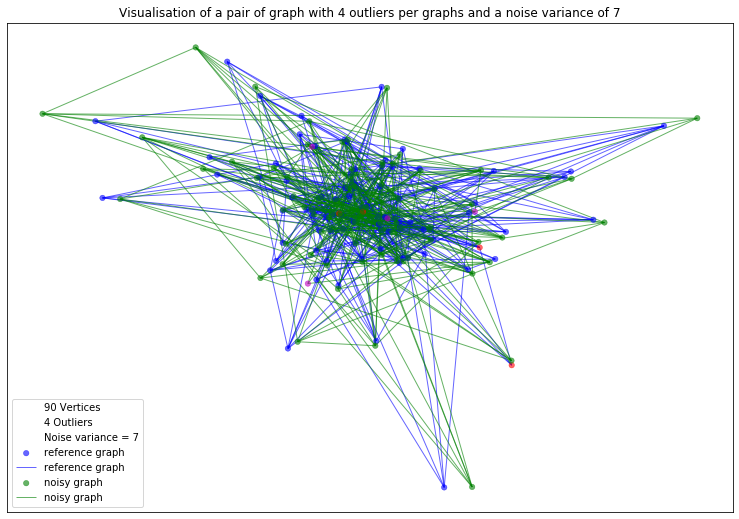

In [235]:
# Load the data
#my_graph = nx.read_gpickle("../generation_graphes/generated_graphs/noise_6.0,outliers_2/0/ref_graph.gpickle")
#my_graph_noisy = nx.read_gpickle("../generation_graphes/generated_graphs/noise_6.0,outliers_2/0/noisy_graph.gpickle")

my_graph = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_7.0,outliers_4/0/ref_graph.gpickle")
my_graph_noisy = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_7.0,outliers_4/0/noisy_graph.gpickle")

# Get the 2D coordinates
acceptable_norm = 1000
get_planar_coords_in_graph(my_graph_noisy,acceptable_norm)
get_planar_coords_in_graph(my_graph,acceptable_norm)

# Prepare the position for the plot
my_pos = {node: my_graph.nodes[node]["coord2D"] for node in my_graph.nodes}
my_pos_noisy = {node: my_graph_noisy.nodes[node]["coord2D"] for node in my_graph_noisy.nodes}

# Prepare the colors where outliers have different colors
nb_vertices = 90
colors_ref = ["blue" if node < nb_vertices else "red" for node in my_graph.nodes]
colors_noisy = ["green" if node < nb_vertices else "m" for node in my_graph_noisy.nodes]

# Prepare the matplotlib ax
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(13,9))
# Draw the graphs
nx.draw_networkx(my_graph, 
                 pos=my_pos, 
                 with_labels=False, 
                 node_size=30, 
                 alpha=0.6, 
                 node_color=colors_ref,
                 edge_color="blue",
                 linewidths=0.5,
                 ax=ax, 
                 label="reference graph")

nx.draw_networkx(my_graph_noisy,
                 pos=my_pos_noisy, 
                 with_labels=False, 
                 node_size=30, 
                 alpha=0.6, 
                 node_color=colors_noisy,
                 edge_color="green",
                 linewidths=0.5,
                 ax=ax, 
                 #style="dotted",
                 label="noisy graph")

# Add blank lines to add elements to the legends
ax.plot([], [], ' ', label="90 Vertices")
ax.plot([], [], ' ', label="4 Outliers")
ax.plot([], [], ' ', label="Noise variance = 7")

plt.title("Visualisation of a pair of graph with 4 outliers per graphs and a noise variance of 7")
plt.legend()
plt.savefig("plots/test.svg")

## Visualisation of the matched nodes

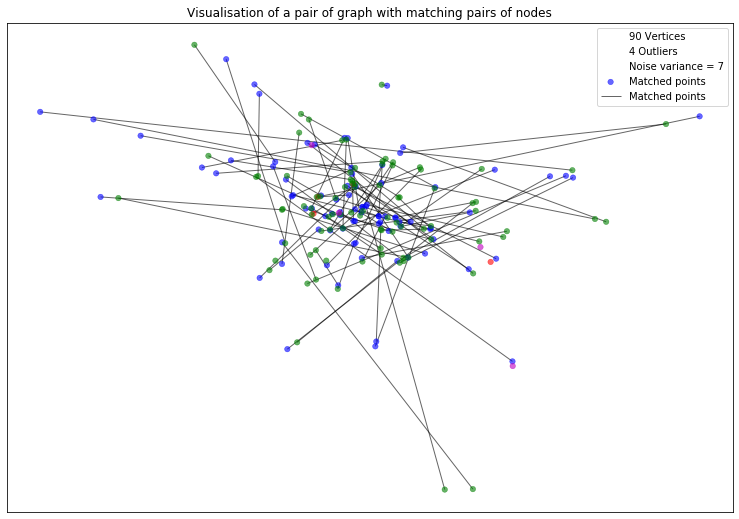

In [236]:
# load the graphs and the permutation matrix
my_graph = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_7.0,outliers_4/0/ref_graph.gpickle")
my_graph_noisy = nx.read_gpickle("../generation_graphes/generated_graphs_big/noise_7.0,outliers_4/0/noisy_graph.gpickle")

ground_truth = np.load("../generation_graphes/generated_graphs_big/noise_7.0,outliers_4/0/ground_truth.npy")
permutation_matrix = np.zeros((len(ground_truth), len(ground_truth)))
for i, elem in enumerate(ground_truth):
    permutation_matrix[i,elem] = 1
    
# We create the graph that will hold the matching of the algorithm
graph_matched = nx.Graph()

# We add all the nodes from both graphs to the matched graph
for node in my_graph:
    graph_matched.add_node("r"+str(node), coord=my_graph.nodes[node]["coord"])
for node in my_graph_noisy:
    graph_matched.add_node("n"+str(node), coord=my_graph_noisy.nodes[node]["coord"])
    
# We add the edges that corresponds to the matched nodes
for ref_node in range(permutation_matrix.shape[0]):
    # We get the corresponding node in the noisy graph
    matched_node = np.where(permutation_matrix[ref_node,:] == 1)[0][0]
    # We add the edge that represent a match
    graph_matched.add_edge("r"+str(ref_node), "n"+str(matched_node))
    
# Get the 2D coordinates
acceptable_norm = 1000
get_planar_coords_in_graph(graph_matched,acceptable_norm)

# Prepare the position for the plot
my_pos = {node: graph_matched.nodes[node]["coord2D"] for node in graph_matched.nodes}

# Prepare the colors where outliers have different colors
nb_vertices = 90
colors_list = []
for node in graph_matched.nodes:
    if int(node[1:]) < nb_vertices and node[0] == "r":
        colors_list.append("blue")
    if int(node[1:]) < nb_vertices and node[0] == "n":
        colors_list.append("green")
    if int(node[1:]) >= nb_vertices and node[0] == "r":
        colors_list.append("red")
    if int(node[1:]) >= nb_vertices and node[0] == "n":
        colors_list.append("m")
        
# Prepare the matplotlib ax
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(13,9))
# Draw the graphs
nx.draw_networkx(graph_matched, 
                 pos=my_pos, 
                 with_labels=False, 
                 node_size=30, 
                 alpha=0.6, 
                 node_color=colors_list,
                 linewidths=0.5,
                 ax=ax, 
                 label="Matched points")

#nx.draw_networkx(my_graph_noisy,
#                 pos=my_pos_noisy, 
#                 with_labels=False, 
#                 node_size=30, 
#                 alpha=0.6, 
#                 node_color=colors_noisy,
#                 edge_color="green",
#                 linewidths=0.5,
#                 ax=ax, 
#                 #style="dotted",
#                 label="noisy graph")

# Add blank lines to add elements to the legends
ax.plot([], [], ' ', label="90 Vertices")
ax.plot([], [], ' ', label="4 Outliers")
ax.plot([], [], ' ', label="Noise variance = 7")

plt.title("Visualisation of a pair of graph with matching pairs of nodes")
plt.legend()
plt.savefig("plots/test_matched.svg")

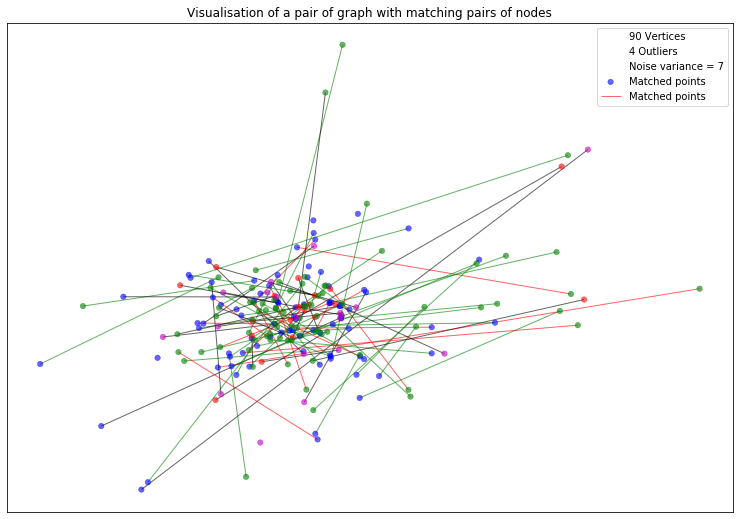

In [238]:
# load the graphs and the permutation matrix
path_to_folder = "../generation_graphes/examples_generated_graphs/noise_30.0,outliers_20/0/"
my_graph = nx.read_gpickle(path_to_folder + "ref_graph.gpickle")
my_graph_noisy = nx.read_gpickle(path_to_folder + "noisy_graph.gpickle")

rrwm_perm_mat = np.transpose(sio.loadmat(path_to_folder+"X_kergm.mat")["X"])
rrwm_perm_mat = np.transpose(rrwm_perm_mat)

ground_truth = np.load(path_to_folder + "ground_truth.npy")
g_t_permutation_matrix = np.zeros((len(ground_truth), len(ground_truth)))
for i, elem in enumerate(ground_truth):
    g_t_permutation_matrix[i,elem] = 1
    
# We create the graph that will hold the matching of the algorithm
graph_matched = nx.Graph()

# We add all the nodes from both graphs to the matched graph
for node in my_graph:
    graph_matched.add_node("r"+str(node), coord=my_graph.nodes[node]["coord"])
for node in my_graph_noisy:
    graph_matched.add_node("n"+str(node), coord=my_graph_noisy.nodes[node]["coord"])
    
# We prepare the color for the edges :
colors_edge = []

# We add the edges that corresponds to the matched nodes
for ref_node in range(rrwm_perm_mat.shape[0]):
    # We get the corresponding node in the noisy graph
    matched_node = np.where(rrwm_perm_mat[ref_node,:] == 1)[0][0]
    
    # We see if it's a good match
    if ref_node < g_t_permutation_matrix.shape[0] and matched_node < g_t_permutation_matrix.shape[1]:
        if g_t_permutation_matrix[ref_node,matched_node] == 1:
            color = "green"
        else:
            color="red"
    else:
        color = "black"
    # We add the edge that represent a match
    graph_matched.add_edge("r"+str(ref_node), "n"+str(matched_node), color=color)

    
# Get the 2D coordinates
acceptable_norm = 1000
get_planar_coords_in_graph(graph_matched,acceptable_norm)

# get the edge colors
color_edges = [graph_matched.edges[edge]["color"] for edge in graph_matched.edges]

# Prepare the position for the plot
my_pos = {node: graph_matched.nodes[node]["coord2D"] for node in graph_matched.nodes}

# Prepare the colors where outliers have different colors
nb_vertices = 90
colors_list = []
for node in graph_matched.nodes:
    if int(node[1:]) < nb_vertices and node[0] == "r":
        colors_list.append("blue")
    if int(node[1:]) < nb_vertices and node[0] == "n":
        colors_list.append("green")
    if int(node[1:]) >= nb_vertices and node[0] == "r":
        colors_list.append("red")
    if int(node[1:]) >= nb_vertices and node[0] == "n":
        colors_list.append("m")
        
# Prepare the matplotlib ax
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(13,9))
# Draw the graphs
nx.draw_networkx(graph_matched, 
                 pos=my_pos, 
                 with_labels=False, 
                 node_size=30, 
                 alpha=0.6, 
                 node_color=colors_list,
                 edge_color=color_edges,
                 linewidths=0.5,
                 ax=ax, 
                 label="Matched points")

# Add blank lines to add elements to the legends
ax.plot([], [], ' ', label="90 Vertices")
ax.plot([], [], ' ', label="4 Outliers")
ax.plot([], [], ' ', label="Noise variance = 7")

plt.title("Visualisation of a pair of graph with matching pairs of nodes")
plt.legend()
plt.savefig("plots/test_matched.svg")